In [ ]:
source("./libs.R")

## 1.Relate ps to motif

### 1.1 load &  merge data sets

In [2]:
### 1.1 load chromVar Z vals 
input.chromVar.jaspar.z <- input.chromVar.jaspar.z %>% as.data.frame %>% rownames_to_column("motif") %>% 
    melt(id = "motif", variable.name = "cell", value.name = "zval")
input.chromVar.jaspar.z %>% head(1)
input.chromVar.jaspar.z %>% dim

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 772 rows [3, 50, 83, 84, 138, 181, 196, 213, 253, 265, 274, 301, 303, 353, 371, 388, 412, 434, 491, 495, ...].”

motif,cell,zval
<chr>,<fct>,<dbl>
MA0004.1_Arnt,Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-1.566904


[1] 8857542       3

In [3]:
### 1.2 load ps

input.pseudotime <- fread("../dat/1910_v2/abd.promoter.long_matrix_w_transcripts_ps.txt") %>% 
    select(cell, ps, celltype)%>%distinct
input.pseudotime%>%dim

[1] 14526     3

In [4]:
### 1.3 merge ps to motif result

output.motif.pt <- merge(input.chromVar.jaspar.z, input.pseudotime)
output.motif.pt %>% head(1)
output.motif.pt %>% dim
output.motif.pt %>% select(cell, celltype) %>% distinct %>% pull(celltype) %>% table
output.motif.pt %>% pull(motif) %>% unique %>% length

output.motif.pt <- output.motif.pt %>% left_join(input.umap.res %>% rename(cell = "barcodes") %>% 
    select(cell, UMAP1, UMAP2, cluster))
output.motif.pt %>% head(1)
output.motif.pt %>% dim

cell,motif,zval,ps,celltype
<fct>,<chr>,<dbl>,<dbl>,<chr>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha


[1] 8410554       5

.
alpha  beta delta 
 6218  7598   710 

[1] 579

Joining, by = "cell"
Warning message:
“Column `cell` joining factor and character vector, coercing into character vector”

cell,motif,zval,ps,celltype,UMAP1,UMAP2,cluster
<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha,-5.102393,1.38682,alpha_2


[1] 8410554       8

### 1.2 plot UMAP to QC

barcodes,UMAP1,UMAP2,cluster,cell_type_overall,subtype,unique_usable_reads,log_usable_counts,frac_duplicated_reads,frac_mito_reads,frac_promoters_used,frac_reads_in_peaks,frac_reads_in_promoters
<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,-5.102393,1.38682,alpha_2,alpha,2,6254,7.865955,0.7902986,0.03428042,0.04337516,0.5978574,0.2646306


[1] 15298    13

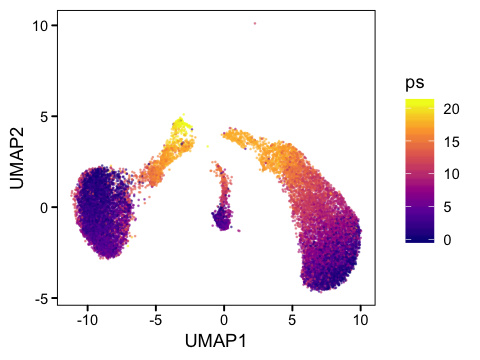

In [6]:
options(repr.plot.width = 4, repr.plot.height = 3)
# filter unkonwn
head(input.umap.res, 1)
dim(input.umap.res)
ggplot(output.motif.pt %>% select(UMAP1, UMAP2, ps) %>% distinct, aes(UMAP1, UMAP2)) + 
    geom_point(aes(color = ps), size = 0.1, alpha = 0.5) + scale_color_viridis_c(option='C') + 
    theme_pubr()
fn <- "../figures/Fig2/subfigs/fig2e.PS_UMAP_qc.pdf"
ggsave(fn, width = 4, height = 3, units = "in", useDingbats = F)
system(paste0("open ", fn))

### 1.3 filter motifs to only selected & smooth along the ps

In [7]:
dmotifs.list <- sapply(c("alpha", "beta", "delta"), function(x) fread("../figures/Fig2/subfigs/fig2_sub_vs_sub.volcation.motif_selection.csv") %>% 
    filter(selected & grepl(x, enrichedIn)) %>% pull(motif))
lapply(dmotifs.list, length)%>%t

alpha,beta,delta
<int>,<int>,<int>
180,80,155


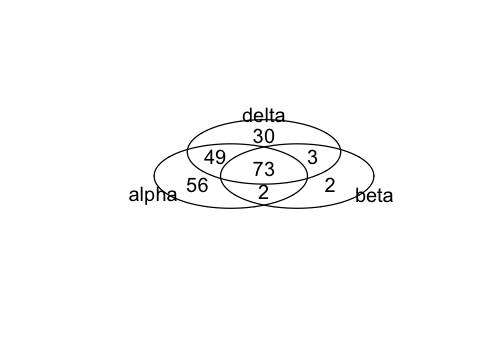

In [8]:
options(repr.plot.width = 4, repr.plot.height = 3)
tmp <- gplots::venn(dmotifs.list)
# dmotifs.list.inter <- attr(tmp, 'intersections')

In [9]:
output.motif.pt <- output.motif.pt %>% separate(motif, c("jaspar", "motif"), sep = "_") %>% 
    select(motif, zval, ps, celltype) %>% rename(pt = "ps")
output.motif.pt %>% head(1)

motif,zval,pt,celltype
<chr>,<dbl>,<dbl>,<chr>
ETV5,0.9046531,13.98913,alpha


In [10]:
pt.max.list <- sapply(c("alpha", "beta", "delta"), function(ct) max((output.motif.pt %>% 
    filter(celltype == ct))$pt))
pt.max.list %>% t

alpha,beta,delta
20.85655,18.49255,14.97356


In [11]:
system.time(smoothed.motif.pt <- do.call(rbind, lapply(c("alpha", "beta", "delta"), 
    function(ct) {
        pt.max <- pt.max.list[[ct]]
        output.motif.pt.sub <- output.motif.pt %>% filter(celltype == ct)
        
        do.call(rbind, mclapply(dmotifs.list[[ct]], function(x) {
            tc <- output.motif.pt.sub %>% filter(motif == x) %>% arrange(pt)
            data.frame(motif = x, ps = seq(0, pt.max, by = 0.05), zval = fun.gamSmooth(tc, 
                new.tps = seq(0, pt.max, by = 0.05)), celltype = ct)
        }, mc.cores = 6))
    })))

   user  system elapsed 
 31.305  15.187  12.223 

In [13]:
smoothed.motif.pt %>% head(2)
smoothed.motif.pt %>% nrow
sapply(c("alpha", "beta", "delta"), function(ct) smoothed.motif.pt %>% filter(celltype == 
    ct) %>% pull(motif) %>% unique %>% length)%>%t

motif,ps,zval,celltype
<fct>,<dbl>,<dbl>,<fct>
NEUROD1,0.00,0.8472072,alpha
NEUROD1,0.05,0.8259909,alpha


[1] 151340

alpha,beta,delta
180,80,155


In [14]:
fwrite(smoothed.motif.pt, "../dat/1910_v2/smoothed.motif.pt.csv")

### 1.4 plot smoothed trajectories for selected motifs 

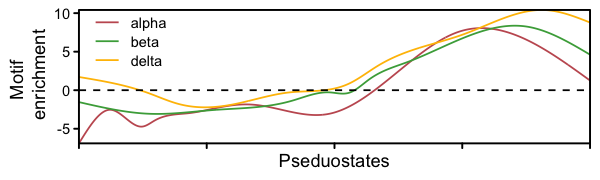

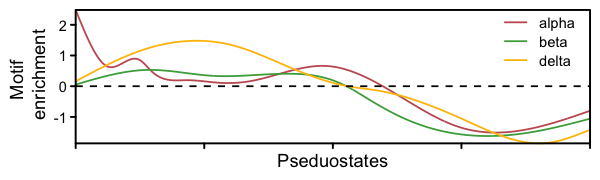

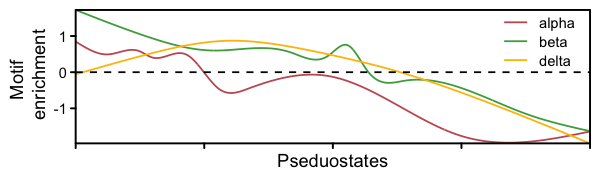

In [83]:
options(repr.plot.width = 5, repr.plot.height = 1.5)

for (m in c("FOS::JUND", "Rfx1", "NEUROD1")) {
    pd <- smoothed.motif.pt %>% filter(motif == m) %>% as.data.table
    scale_this <- function(x) (x - min(x))/(max(x) - min(x))
    
    pd[, `:=`(ps.scaled, scale_this(ps)), by = celltype]
    p <- ggplot(pd, aes(ps.scaled, zval)) + geom_line(aes(color = celltype)) + geom_hline(yintercept = 0, 
        linetype = 2) + theme_pubr() + scale_color_manual(values = cols.celltype) + 
        theme(axis.text.x = element_blank(), legend.key.height = unit(4, "mm"), legend.key = element_blank(), 
            legend.background = element_blank(), legend.title = element_blank(), 
            legend.position = c(ifelse(m == "FOS::JUND", 0.1, 0.9), 0.8)) + coord_cartesian(expand = F, 
        clip = "off") + ylab("Motif \n\n enrichment") + xlab("Pseduostates")
    print(p)
    
    fn <- paste0("../figures/Fig2/subfigs/fig2f_motif_", m, "_ps_lines.pdf")
    ggsave(fn, p, width = 5, height = 1.5, units = "in")
    system(paste0("open ", fn))
    fwrite(p$data, file = sub(".pdf", ".csv", fn), row.names = T)
    system(paste0("open ", sub(".pdf", ".csv", fn)))
    
}

## 2. Motif heatmap along ps

In [4]:
smoothed.motif.pt <- fread("../dat/1910_v2/smoothed.motif.pt.csv")
smoothed.motif.pt%>%head(2)

motif,ps,zval,celltype
NEUROD1,0.00,0.8472072,alpha
NEUROD1,0.05,0.8259909,alpha


### 2.0 substate annotation along ps

In [9]:
output.motif.pt%>%head(2)

cell,motif,zval,ps,celltype,UMAP1,UMAP2,cluster
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0765.1_ETV5,0.9046531,13.98913,alpha,-5.102393,1.38682,alpha_2
Islet1fresh_AGACACCTAAGAGGCAAAGGAGTAGGCTC,MA0641.1_ELF4,1.5014651,13.98913,alpha,-5.102393,1.38682,alpha_2


### 2.1 scaled to 0-1 for each motif 

In [10]:
smoothed.motif.pt.scaled.list <- sapply(c("alpha", "beta", "delta"), function(ct) t(apply(smoothed.motif.pt %>% 
    filter(celltype == ct) %>% select(-celltype) %>% spread(ps, zval) %>% column_to_rownames("motif"), 
    1, function(x) (x - min(x))/(max(x) - min(x)))))

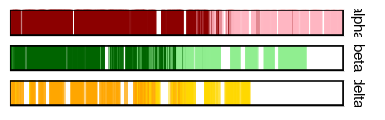

In [13]:
options(repr.plot.width = 154.196/72 * 1.5, repr.plot.height = 6/72 * 4 * 3)
pd.anno.celltype <- output.motif.pt %>% mutate(ps = round(ps, 2)) %>% separate(cluster, 
    c("celltype", "subtype"), sep = "_") %>% group_by(celltype, ps) %>% summarise(subtype = Modes(as.numeric(subtype))[1]) %>% 
    mutate(subtype = as.factor(subtype)) %>% as.data.frame() %>% unite(subtype, c(1, 
    3), sep = "_", remove = F)

ggplot(pd.anno.celltype) + geom_rect(aes(xmin = ps - 0.1, xmax = ps + 0.1, fill = subtype), 
    ymin = 0, ymax = 1, alpha = 0.5) + theme_pubr() + scale_fill_manual(values = cols.celltype) + 
    coord_cartesian(expand = F) + facet_grid(celltype ~ ., scales = "free_x") + theme(legend.position = "none", 
    axis.text.x = element_blank(), axis.ticks = element_blank())

cell,motif,zval,ps,celltype,UMAP1,UMAP2,cluster,ps_bin,ps_bin_idx
Islet3fresh_AGACACCTACTCGCTAAAGGCTATGGCTCTGA,MA0684.1_RUNX3,-0.7241202,0.1583691,alpha,-9.345331,0.6996058,alpha_1,"[0,0.209)",1


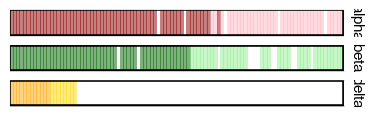

In [14]:
options(repr.plot.width = 154.196/72 * 1.5, repr.plot.height = 6/72 * 4 * 3)

ps.range <- lapply(c("alpha", "beta", "delta"), function(ct) output.motif.pt %>% filter(celltype == 
    ct) %>% pull(ps) %>% range)
names(ps.range) <- c("alpha", "beta", "delta")

                   
N.bin <- 101
N.bin.d<- 21
ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1], ps.range$alpha[2] + 1e-05, length.out = N.bin)
ps.bks$beta <- seq(ps.range$beta[1], ps.range$beta[2] + 1e-05, length.out = N.bin)
ps.bks$delta <- seq(ps.range$delta[1], ps.range$delta[2] + 1e-05, length.out = N.bin.d)

pd.anno.celltype <- rbind(output.motif.pt %>% filter(celltype == "alpha") %>% mutate(ps_bin = cut(ps, 
    breaks = ps.bks$alpha, include.lowest = T, right = F)) %>% mutate(ps_bin_idx = as.numeric(ps_bin)), 
    output.motif.pt %>% filter(celltype == "beta") %>% mutate(ps_bin = cut(ps, breaks = ps.bks$beta, 
        include.lowest = T, right = F)) %>% mutate(ps_bin_idx = as.numeric(ps_bin)), 
    output.motif.pt %>% filter(celltype == "delta") %>% mutate(ps_bin = cut(ps, breaks = ps.bks$delta, 
        include.lowest = T, right = F)) %>% mutate(ps_bin_idx = as.numeric(ps_bin))) %>% 
    arrange(celltype, ps_bin_idx)

pd.anno.celltype %>% head(1)
                   
pd.anno.celltype.2 <- pd.anno.celltype %>% group_by(celltype, ps_bin_idx) %>% summarise(subtype = Modes(cluster)[1]) %>% 
    as.data.frame()
ggplot(pd.anno.celltype.2) + geom_rect(aes(xmin = ps_bin_idx - 0.5, xmax = ps_bin_idx + 
    0.5, fill = subtype), ymin = 0, ymax = 1, alpha = 0.5) + theme_pubr() + scale_fill_manual(values = cols.celltype) + 
    coord_cartesian(expand = F) + facet_grid(celltype ~ ., scales = "free_x") + theme(legend.position = "none", 
    axis.text.x = element_blank(), axis.ticks = element_blank())

cell,motif,zval,ps,celltype,UMAP1,UMAP2,cluster,ps_bin,ps_bin_idx
Islet3fresh_AGACACCTTCCTGAGCTCTCTCCGAGGCGAAG,MA0762.1_ETV2,1.118803,7.126406e-06,alpha,-9.463293,0.9801769,alpha_1,"[0,0.05)",1


Warning message:
“Removed 3 rows containing missing values (geom_rect).”

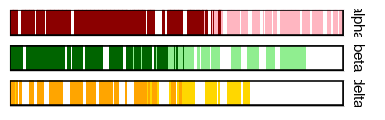

In [15]:
options(repr.plot.width = 154.196/72 * 1.5, repr.plot.height = 6/72 * 4 * 3)

ps.range <- lapply(c("alpha", "beta", "delta"), function(ct) output.motif.pt %>% 
    filter(celltype == ct) %>% pull(ps) %>% range)
names(ps.range) <- c("alpha", "beta", "delta")


ps.bks <- list()
ps.bks$alpha <- seq(ps.range$alpha[1], ps.range$alpha[2] + 1e-05, by = 0.05)
ps.bks$beta <- seq(ps.range$beta[1], ps.range$beta[2] + 1e-05, by = 0.05)
ps.bks$delta <- seq(ps.range$delta[1], ps.range$delta[2] + 1e-05, by = 0.05)

pd.anno.celltype <- rbind(output.motif.pt %>% filter(celltype == "alpha") %>% mutate(ps_bin = cut(ps, 
    breaks = ps.bks$alpha, include.lowest = T, right = F)) %>% mutate(ps_bin_idx = as.numeric(ps_bin)), 
    output.motif.pt %>% filter(celltype == "beta") %>% mutate(ps_bin = cut(ps, breaks = ps.bks$beta, 
        include.lowest = T, right = F)) %>% mutate(ps_bin_idx = as.numeric(ps_bin)), 
    output.motif.pt %>% filter(celltype == "delta") %>% mutate(ps_bin = cut(ps, breaks = ps.bks$delta, 
        include.lowest = T, right = F)) %>% mutate(ps_bin_idx = as.numeric(ps_bin))) %>% 
    arrange(celltype, ps_bin_idx)

pd.anno.celltype %>% head(1)

pd.anno.celltype.2 <- pd.anno.celltype %>% group_by(celltype, ps_bin_idx) %>% summarise(subtype = Modes(cluster)[1]) %>% 
    as.data.frame()
ggplot(pd.anno.celltype.2) + geom_rect(aes(xmin = ps_bin_idx - 0.5, xmax = ps_bin_idx + 
    0.5, fill = subtype), ymin = 0, ymax = 1) + theme_pubr() + scale_fill_manual(values = cols.celltype) + 
    coord_cartesian(expand = F) + facet_grid(celltype ~ ., scales = "free_x") + theme(legend.position = "none", 
    axis.text.x = element_blank(), axis.ticks = element_blank())

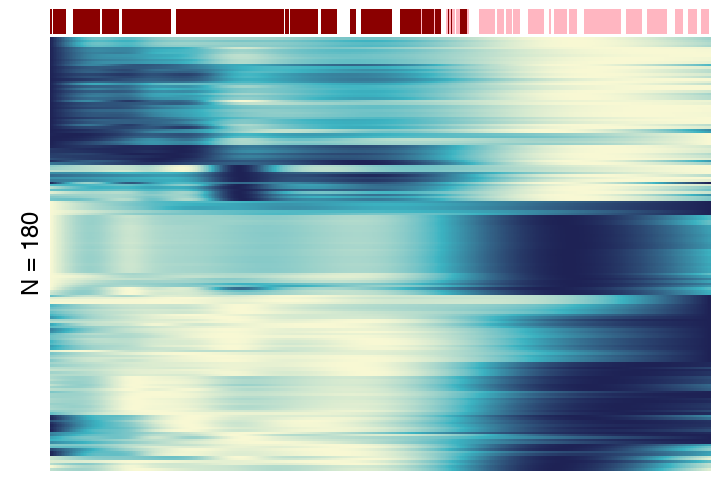

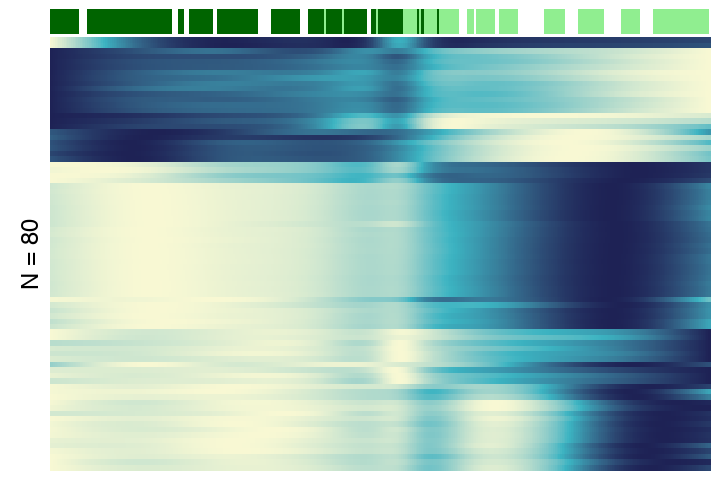

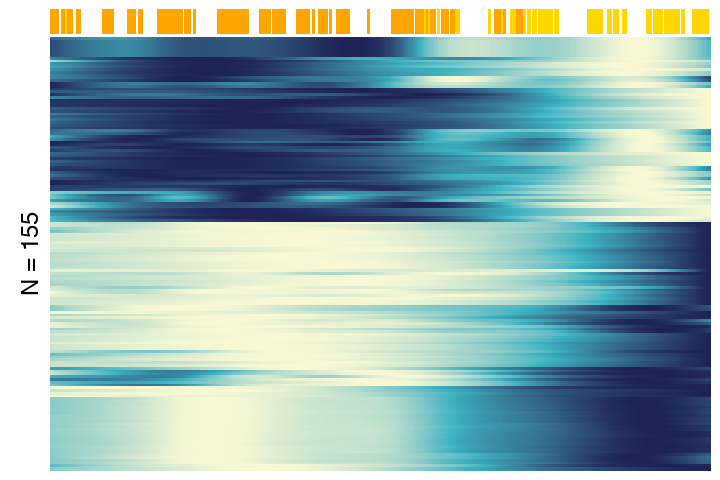

In [83]:
for (ct in c("alpha", "beta", "delta")) {
    cols <- list(alpha = c(cols.celltype["alpha_1"], cols.celltype["alpha_2"]), beta = c(cols.celltype["beta_1"], 
        cols.celltype["beta_2"]), delta = c(cols.celltype["delta_1"], cols.celltype["delta_2"]))
    ncols <- lapply(smoothed.motif.pt.scaled.list, ncol)
    
    difs <- setdiff(1:ncols[[ct]], pd.anno.celltype.2 %>% filter(celltype == ct) %>% 
        pull(ps_bin_idx))
    
    
    pd.anno <- pd.anno.celltype.2 %>% filter(celltype == ct) %>% mutate(subtype = as.numeric(factor(subtype))) %>% 
        rbind(data.frame(celltype = ct, ps_bin_idx = difs, subtype = 0)) %>% spread(ps_bin_idx, 
        subtype, fill = 0) %>% column_to_rownames("celltype")
    
    options(repr.plot.width = 6, repr.plot.height = 4)
    column_ha <- HeatmapAnnotation(celltype = pd.anno %>% as.character, col = list(celltype = c(`1` = cols[[ct]][[1]], 
        `2` = cols[[ct]][[2]], `0` = NA)), show_legend = F)
    nr <- smoothed.motif.pt.scaled.list[[ct]] %>% nrow
    ht <- Heatmap(smoothed.motif.pt.scaled.list[[ct]], name = "motif_activity", cluster_columns = F, 
        row_title = paste("N =", nr), row_dend_reorder = F, clustering_method_rows = "ward.D", 
        clustering_distance_rows = "euclidean", show_heatmap_legend = F, show_row_dend = F, 
        show_row_names = F, show_column_names = F, top_annotation = column_ha, col = cols.hm.avg.tf(50))
    draw(ht)
    fn <- paste0("../figures/Fig2/subfigs/fig2e_motif_", ct, "_ps_hm.pdf")
    
    pdf(file = fn, height = 5.4/180 * nr, width = 6, family = "Arial")
    draw(ht)
    dev.off()
    system(paste0("open ", fn))
    fwrite(x = smoothed.motif.pt.scaled.list[[ct]][row_order(ht)[[1]], ] %>% as.data.frame, 
        file = sub(".pdf", ".csv", fn), row.names = T)
    system(paste0("open ", sub(".pdf", ".csv", fn)))
}